In [3]:
%%capture
!pip install -r requirements.txt

In [2]:
import pandas as pd
from dotenv import load_dotenv
import torch as t
import pandas as pd
from tools.globals import load_country_globals
from tqdm import tqdm
from nnsight import LanguageModel
from transformers import AutoTokenizer

load_country_globals()

device = t.device(
    "mps" if t.backends.mps.is_available() else "cuda" if t.cuda.is_available() else "cpu"
)
load_dotenv()
t.set_grad_enabled(False)

t.manual_seed(42)
if t.cuda.is_available():
    t.cuda.manual_seed_all(42)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
prompt_suffix = {
    "English": "My guess is **",
    "Turkish": "Tahminim **",
    "French": "Ma supposition est **",
    "Russian": "Моё предположение **",
    "Bengali": "আমার অনুমান হলো **",
}

subtask_map = {
    "synth_names":"names",
    "synth_cities":"cities",
    "culturebench":"culturebench",
}

def eval_or_skip(txt):
    try:
        return eval(txt)
    except:
        return None

country_to_suffix= {"Turkey": "tr", "France": "fr", "Russia": "ru", "Bangladesh": "bn", "United States":"us"}

### Load Model

In [4]:
tokenizer = AutoTokenizer.from_pretrained("google/gemma-2-9b-it")
nnmodel = LanguageModel('/dlabscratch1/public/llm_weights/gemma_hf/gemma-2-9b-it', 
                        device_map='cuda:0', 
                        dispatch=True, 
                        torch_dtype=t.bfloat16)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

### Load steering vectors

In [ ]:
from tools.steering import load_steering_vec_map

steering_vec_map = load_steering_vec_map()

### Load datasets

In [6]:
# Original dataset
test_data = pd.read_csv("model_gen/all_models_eval_subset.csv")
test_data = test_data.query("model=='gemma2_9b_it'").copy()

test_data["options"] = test_data["options"].apply(eval_or_skip)
test_data.dropna(subset=["options"], inplace=True)

src_map = {
"synth_names":"names",
"synth_cities":"cities",
"culturebench":"culturebench",
}

test_data["subtask"] = test_data["source_id"].apply(lambda x: src_map.get(x, "culturedistil"))
test_data = test_data.query("hint==False").copy()

test_data.shape

(5987, 19)

In [ ]:
# Option swapped dataset
test_data_swap = pd.read_csv("model_gen/all_models_eval_subset_swapped.csv")
test_data_swap = test_data_swap.query("model=='gemma2_9b_it'").copy()

test_data_swap["options"] = test_data_swap["options"].apply(eval_or_skip)
test_data_swap.dropna(subset=["options"], inplace=True)

src_map = {
"synth_names":"names",
"synth_cities":"cities",
"culturebench":"culturebench",
}

test_data_swap["subtask"] = test_data_swap["source_id"].apply(lambda x: src_map.get(x, "culturedistil"))
test_data_swap = test_data_swap.query("hint==False").copy()
test_data_swap.shape

(5987, 21)

In [ ]:
from tools.steering import run_steering_binary
# First, we must run the no steering case that will be used as a baseline

batch_size = 64
folder = "caa/gemma2_9b_it_binary"

no_steer_df = run_steering_binary(nnmodel,
                    tokenizer,
                    steering_vec_map, 
                    test_data, 
                    [21], 
                    [0], 
                    batch_size, 
                    vector_type="none", folder=folder, filename="nosteer")


In [ ]:
from tools.steering import run_steering_binary

batch_size = 64

folder = "caa/gemma2_9b_it_binary"

all_layers = [15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30]
main_layers = [21,22,23,24,25,26,27]
alphas = [-2,-1, 1, 2]

# All experiments presented in the paper
# CAUTION: These experiments are computationally expensive and may take a long time to run
for vec_type, which_layers in [("perculture_en", all_layers), 
                             ("perculture_trans", main_layers), 
                             ("en_universal_loo", main_layers), 
                             ("trans_universal_loo", main_layers), 
                             ("implicit", all_layers), 
                             ("en_names", main_layers), 
                             ("pertask_en", main_layers), 
                             ("perculture_en", main_layers)]:
    run_steering_binary(nnmodel,
                        tokenizer,
                        steering_vec_map, 
                        test_data if vec_type != "perculture_en" else test_data_swap, 
                        which_layers, 
                        alphas, 
                        batch_size, 
                        vector_type=vec_type, folder=folder, filename=f"{vec_type}_{'swapped' if vec_type == 'perculture_en' else ''}")


### Inspect & Visualize results

In [ ]:
perculture_en_df = pd.read_csv("caa/gemma2_9b_it_binary/perculture_en.csv")

perculture_trans_df = pd.read_csv("caa/gemma2_9b_it_binary/perculture_trans.csv")

en_univ_df = pd.read_csv("caa/gemma2_9b_it_binary/en_universal_loo.csv")

trans_univ_df = pd.read_csv("caa/gemma2_9b_it_binary/trans_universal_loo.csv")

pertask_df = pd.read_csv("caa/gemma2_9b_it_binary/pertask_en.csv")

name_df = pd.read_csv("caa/gemma2_9b_it_binary/en_names.csv")

implicit_df = pd.read_csv("caa/gemma2_9b_it_binary/implicit.csv")

perculture_en_swapped_df = pd.read_csv("caa/gemma2_9b_it_binary/perculture_en_swapped.csv")
perculture_en_swapped_df["vector"] = "perculture_en_swapped"

steer_df = pd.concat([perculture_en_df, perculture_trans_df, en_univ_df, trans_univ_df, pertask_df, name_df, implicit_df, perculture_en_swapped_df])


In [9]:
def get_abs_type(out):
    if str(int(out["ans_west_idx"])) in str(out["steer_out"]):
        out["ans_type"] = "west"
    elif str(int(out["ans_local_idx"])) in str(out["steer_out"]):
        out["ans_type"] = "local"
    else:
        out["ans_type"] = "none"
    return out["ans_type"]

steer_df["ans_type"] = steer_df.apply(get_abs_type, axis=1)

In [ ]:
# Get the no steer results and merge them with the steer results for comparison
no_steer_res = pd.read_csv("caa/gemma2_9b_it_binary/nosteer.csv")
no_steer_res["unique_id"] = no_steer_res["question_id"].astype(str) + no_steer_res["lang"] + no_steer_res["country"] + no_steer_res["hint"].astype(str)

steer_df["unique_id"] = steer_df["question_id"].astype(str) + steer_df["lang"] + steer_df["country"] + steer_df["hint"].astype(str)
unique_ids = set(steer_df["unique_id"].unique())

no_steer_res = no_steer_res.query("unique_id in @unique_ids").copy()

dfs = []
for l in steer_df["layer"].unique():
    n = no_steer_res.copy()
    n["vector"] = "none"
    n["layer"]=l
    dfs.append(n)
no_steer_res = pd.concat(dfs)


steer_df = [steer_df, no_steer_res]
steer_df = pd.concat(steer_df)

steer_df.drop(columns=["steer_prob"], inplace=True)

In [ ]:
# Get the explicit localization results (i.e. prompts with context/hint)
w_context = pd.read_csv("model_gen/all_models_eval_subset.csv").query("model =='gemma2_9b_it' and hint==True").copy()

w_context["key"] = w_context["question_id"] + w_context["country"]

steer_df["key"] = steer_df["question_id"] + steer_df["country"]
keys = set(steer_df["key"].unique())
w_context = w_context.query("key in @keys").copy()

src_map = {
"synth_names":"names",
"synth_cities":"cities",
"culturebench":"culturebench",
}

w_context["subtask"] = w_context["source_id"].apply(lambda x: src_map.get(x, "culturedistil"))

w_context["local_ans"] = (w_context["ans_type"] == "local").astype(int)
w_context["west_ans"] = (w_context["ans_type"] == "west").astype(int)
w_context["no_ans"] = (w_context["ans_type"] == "none").astype(int)



In [ ]:
steer_df["local_ans"] = (steer_df["ans_type"] == "local").astype(int)
steer_df["west_ans"] = (steer_df["ans_type"] == "west").astype(int)
steer_df["no_ans"] = (steer_df["ans_type"] == "none").astype(int)

steer_df = steer_df.merge(
    steer_df.query("alpha == 0")[["question_id", "country", "lang", "hint", "subtask", "layer", "local_ans", "west_ans", "no_ans"]].rename(columns={"local_ans": "local_ans_base", "west_ans": "west_ans_base", "no_ans": "no_ans_base"}),
    on=["question_id","lang", "subtask", "layer", "hint", "country"],
    how="inner"
)
steer_df["delta_local_ans"] = steer_df["local_ans"] - steer_df["local_ans_base"]
steer_df["delta_west_ans"] = steer_df["west_ans"] - steer_df["west_ans_base"]
steer_df["delta_no_ans"] = steer_df["no_ans"] - steer_df["no_ans_base"]

In [ ]:
steer_df["translated"] = steer_df.apply(lambda x: x["lang"] != "English" or x["country"]=='United States', axis=1)
w_context["translated"] = w_context.apply(lambda x: x["lang"] != "English" or x["country"]=='United States', axis=1)

In [ ]:
vector_renaming = {"perculture_en": "per-culture (en)", 
                   "perculture_trans": "per-culture (translated)", 
                   "en_names": "names (en)",
                   "en_universal_loo": "held-out universal (en)",
                   "trans_universal_loo": "held-out universal (translated)",
                   "transuniversal": "universal (translated)",
                   "enuniversal": "universal (en)"}

In [ ]:
## per culture vectors
vectors_to_look = ["perculture_en", "perculture_trans", "en_names", "en_universal_loo", "trans_universal_loo", "transuniversal", "enuniversal"]

disp_df = steer_df.query("vector in @vectors_to_look and alpha<3").merge(w_context[["key", "lang", "local_ans", "west_ans", "no_ans"]], on=["key","lang"], how="inner", suffixes=("", "_hint"))
best_steering_performance = disp_df.groupby(["vector","alpha","layer", "country", "translated"])[["local_ans","local_ans_base","local_ans_hint"]].mean().reset_index()

best_alpha_layer = best_steering_performance.loc[best_steering_performance.groupby(["vector","country","translated"])["local_ans"].idxmax()]

best_alpha_layer["vector"] = best_alpha_layer["vector"].apply(lambda x: vector_renaming[x])
best_alpha_layer.rename(columns={"local_ans": "local_ans_steer", "local_ans_base": "local_ans_no_steer", "local_ans_hint": "local_ans_hinted"}, inplace=True)
best_alpha_layer

,vector,alpha,layer,country,translated,local_ans_steer,local_ans_no_steer,local_ans_hinted
486,per-culture (en),2,21,Bangladesh,False,0.769896,0.543253,0.955017
487,per-culture (en),2,21,Bangladesh,True,0.738754,0.628028,0.894464
380,per-culture (en),1,25,France,False,0.693103,0.524138,0.898276
489,per-culture (en),2,21,France,True,0.612069,0.546552,0.884483
526,per-culture (en),2,25,Russia,False,0.872072,0.497297,0.926126
...,...,...,...,...,...,...,...,...
2570,held-out universal (translated),2,27,Russia,False,0.556757,0.497297,0.926126
2553,held-out universal (translated),2,25,Russia,True,0.690090,0.531532,0.877477
2572,held-out universal (translated),2,27,Turkey,False,0.634286,0.548571,0.944286
2573,held-out universal (translated),2,27,Turkey,True,0.680000,0.558571,0.918571


In [ ]:
# per-task 
vectors_to_look = ["pertask_en","en_names","perculture_en"]

disp_df = steer_df.query("vector in @vectors_to_look and lang=='English' and alpha<3").merge(w_context[["key", "lang", "local_ans", "west_ans", "no_ans"]], on=["key","lang"], how="inner", suffixes=("", "_hint"))
best_steering_performance = disp_df.groupby(["vector","alpha","layer", "subtask"])[["local_ans","local_ans_base","local_ans_hint"]].mean().reset_index()

best_alpha_layer = best_steering_performance.loc[best_steering_performance.groupby(["vector","subtask"])["local_ans"].idxmax()]

best_alpha_layer["vector"] = best_alpha_layer["vector"].apply(lambda x: vector_renaming[x])
best_alpha_layer.rename(columns={"local_ans": "local_ans_steer", "local_ans_base": "local_ans_no_steer", "local_ans_hint": "local_ans_hinted"}, inplace=True)
best_alpha_layer


,vector,alpha,layer,subtask,local_ans_steer,local_ans_no_steer,local_ans_hinted
232,per-culture (en),2,25,cities,0.872816,0.466019,1.000000
225,per-culture (en),2,23,culturebench,0.793011,0.741935,0.881720
234,per-culture (en),2,25,culturedistil,0.614173,0.484252,0.844488
227,per-culture (en),2,23,names,0.733564,0.551903,0.914360
500,names (en),2,21,cities,0.896117,0.466019,1.000000
501,names (en),2,21,culturebench,0.798387,0.741935,0.881720
502,names (en),2,21,culturedistil,0.624016,0.484252,0.844488
503,names (en),2,21,names,0.770761,0.551903,0.914360
736,per-task-culture (en),1,25,cities,0.806796,0.466019,1.000000
785,per-task-culture (en),2,21,culturebench,0.776882,0.741935,0.881720


In [14]:
en_implicit_results = steer_df.query("vector=='implicit' and lang=='English'").copy()
en_implicit_results["country"] = "United States"
en_implicit_results["translated"] = True
en_implicit_results["alpha"] = - en_implicit_results["alpha"]
en_implicit_results[["ans_local", "ans_west", "ans_local_idx", "ans_west_idx"]] = en_implicit_results[["ans_west","ans_local", "ans_west_idx", "ans_local_idx"]]
en_implicit_results[["local_ans", "west_ans", "local_ans_base", "west_ans_base"]] = en_implicit_results[["west_ans","local_ans", "west_ans_base", "local_ans_base"]]
en_implicit_results["delta_local_ans"] = en_implicit_results["local_ans"] - en_implicit_results["local_ans_base"]
en_implicit_results["delta_west_ans"] = en_implicit_results["west_ans"] - en_implicit_results["west_ans_base"]

In [ ]:
us_question_ids = set(steer_df.query("country=='United States'")["question_id"].unique())

disp_df = pd.concat([steer_df.query("vector=='implicit' and lang!='English' and alpha<3"), en_implicit_results.query("question_id in @us_question_ids")]).merge(w_context[["key", "lang", "local_ans", "west_ans", "no_ans"]], on=["key","lang"], how="inner", suffixes=("", "_hint"))
best_steering_performance = disp_df.groupby(["vector","alpha","layer", "country", "translated"])[["local_ans","local_ans_base","local_ans_hint"]].mean().reset_index()

best_alpha_layer = best_steering_performance.loc[best_steering_performance.groupby(["vector","country","translated"])["local_ans"].idxmax()]

best_alpha_layer["vector"] = best_alpha_layer["vector"].apply(lambda x: vector_renaming[x])
best_alpha_layer.rename(columns={"local_ans": "local_ans_steer", "local_ans_base": "local_ans_no_steer", "local_ans_hint": "local_ans_hinted"}, inplace=True)
best_alpha_layer.drop(columns=["local_ans_hinted"], inplace=True)
best_alpha_layer

,vector,alpha,layer,country,translated,local_ans_steer,local_ans_no_steer
210,implicit,1,25,Bangladesh,True,0.695502,0.628028
296,implicit,2,26,France,True,0.594828,0.546552
212,implicit,1,25,Russia,True,0.614414,0.531532
283,implicit,2,23,Turkey,True,0.654286,0.558571
214,implicit,1,25,United States,True,0.621392,0.517827


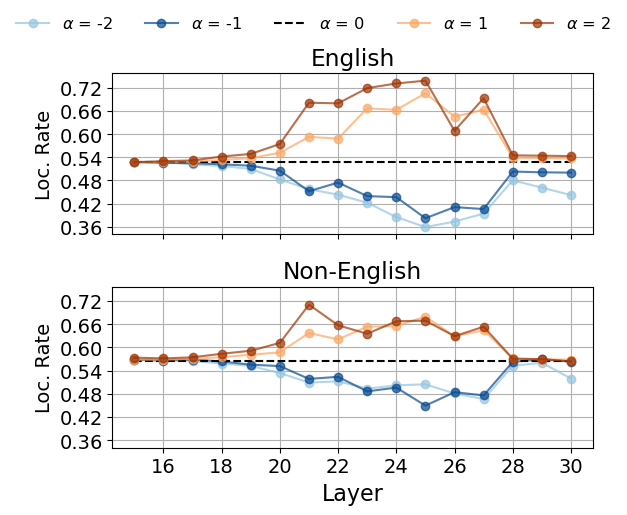

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


query = "lang!='' and alpha<3 and alpha>-3"
disp_df = steer_df.query("(vector=='perculture_en' or vector=='none') and alpha<3").copy()
disp_df["title"] = disp_df["lang"].apply(lambda x: "English" if x == "English" else "Non-English")


disp_df["layer"] = disp_df["layer"].astype(int)


all_alphas = sorted(disp_df["alpha"].unique())  # ascending order
negative_alphas = [a for a in all_alphas if a < 0]
positive_alphas = [a for a in all_alphas if a > 0]

neg_colors = plt.cm.Blues(np.linspace(0.4, 0.9, len(negative_alphas)))
pos_colors = plt.cm.Oranges(np.linspace(0.4, 0.9, len(positive_alphas)))

alpha_color_map = {}
for alpha_val, color_val in zip(negative_alphas, neg_colors):
    alpha_color_map[alpha_val] = color_val
for alpha_val, color_val in zip(positive_alphas, pos_colors):
    alpha_color_map[alpha_val] = color_val

plt.rcParams.update({'font.size': 14})
plt.rcParams.update({
    'xtick.labelsize': 12, 
    'ytick.labelsize': 12, 
    'axes.labelsize': 13
})

subtasks = disp_df["title"].unique()
fig, axes = plt.subplots(len(subtasks), 1, figsize=(6, 5), sharex=True, sharey=True)
if not isinstance(axes, np.ndarray):
    axes = [axes]  # Ensure we have an iterable of axes


for ax, (src, group) in zip(axes, disp_df.groupby("title")):

    # Sort alpha in ascending order so the legend goes from negative -> positive
    for alpha_val in sorted(group["alpha"].unique()):
        if alpha_val == 0:
            pass
        
        alpha_grp = group[group["alpha"] == alpha_val]
        
        # For each layer, we gather all local_ans values
        layer_groups = alpha_grp.groupby("layer")["local_ans"].apply(list)
        
        # Sort layers
        layers = sorted(layer_groups.index)
        means, ci_low, ci_high = [], [], []
        
        for lyr in layers:
            arr = np.array(layer_groups.loc[lyr], dtype=float)
            m = arr.mean()
            # Standard error
            sem = arr.std(ddof=1) / np.sqrt(len(arr))
            # 95% CI ~ mean ± 1.96*SEM
            ci = 1.96 * sem
            
            means.append(m)
            ci_low.append(m - ci)
            ci_high.append(m + ci)
        
        if alpha_val == 0:
            ax.plot(
                layers, means,
                label=f"$\\alpha$ = {alpha_val}",
                linestyle="dashed",
                color="black"
            )
        else:
            # Get color for current alpha
            color = alpha_color_map[alpha_val]
            ax.plot(
                layers, means,
                label=f"$\\alpha$ = {alpha_val}",
                color=color,
                marker='o',
                alpha=0.7
            )
        
    ax.set_title(src)
    ax.set_ylabel("Loc. Rate")
    ax.grid(True)
    handles, labels = [], []
    for ax in axes:
        for handle, label in zip(*ax.get_legend_handles_labels()):
            if label not in labels:
                handles.append(handle)
                labels.append(label)

    ax.yaxis.set_major_locator(plt.MaxNLocator(nbins=8))
    ax.plot()

axes[-1].set_xlabel("Layer")

fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=len(labels), fontsize='small', frameon=False)

for ax in axes:
    ax.tick_params(axis='both', which='major', labelsize=14)

    # Ensure x-ticks are integers
    for ax in axes:
        ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
# Make x label and y label font size larger
axes[-1].set_xlabel("Layer", fontsize=16)
for ax in axes:
    ax.set_ylabel("Loc. Rate", fontsize=14)
# Move legend to the top

plt.tight_layout(pad=1.0)
# Save the figure
fig.savefig("steering_eng_noneng_large.pdf", dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

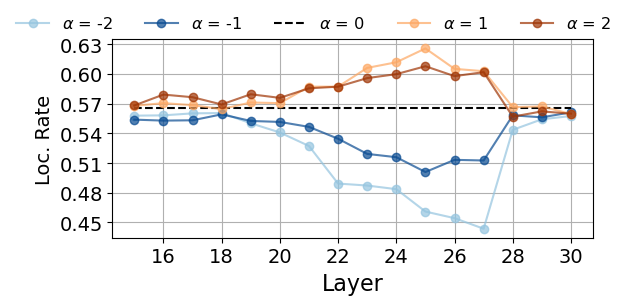

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

us_question_ids = set(steer_df.query("country=='United States' and vector=='enmicro'")["question_id"].unique())
query = "lang!='' and alpha<3 and alpha>-3"
disp_df = pd.concat([steer_df.query("(vector=='implicit' or vector=='none') and lang!='English' and alpha<3"), en_implicit_results.query("question_id in @us_question_ids")]).merge(w_context[["key", "lang", "local_ans", "west_ans", "no_ans"]], on=["key","lang"], how="inner", suffixes=("", "_hint"))
disp_df["title"] = disp_df["lang"].apply(lambda x: "" if x == "English" else "")


disp_df["layer"] = disp_df["layer"].astype(int)


all_alphas = sorted(disp_df["alpha"].unique())  # ascending order
negative_alphas = [a for a in all_alphas if a < 0]
positive_alphas = [a for a in all_alphas if a > 0]

neg_colors = plt.cm.Blues(np.linspace(0.4, 0.9, len(negative_alphas)))
pos_colors = plt.cm.Oranges(np.linspace(0.4, 0.9, len(positive_alphas)))

alpha_color_map = {}
for alpha_val, color_val in zip(negative_alphas, neg_colors):
    alpha_color_map[alpha_val] = color_val
for alpha_val, color_val in zip(positive_alphas, pos_colors):
    alpha_color_map[alpha_val] = color_val

plt.rcParams.update({'font.size': 14})
plt.rcParams.update({
    'xtick.labelsize': 12, 
    'ytick.labelsize': 12, 
    'axes.labelsize': 13
})

subtasks = disp_df["title"].unique()
fig, axes = plt.subplots(len(subtasks), 1, figsize=(6, 3), sharex=True, sharey=True)
if not isinstance(axes, np.ndarray):
    axes = [axes]  # Ensure we have an iterable of axes


for ax, (src, group) in zip(axes, disp_df.groupby("title")):

    # Sort alpha in ascending order so the legend goes from negative -> positive
    for alpha_val in sorted(group["alpha"].unique()):
        if alpha_val == 0:
            pass
        
        alpha_grp = group[group["alpha"] == alpha_val]
        
        # For each layer, we gather all local_ans values
        layer_groups = alpha_grp.groupby("layer")["local_ans"].apply(list)
        
        # Sort layers
        layers = sorted(layer_groups.index)
        means, ci_low, ci_high = [], [], []
        
        for lyr in layers:
            arr = np.array(layer_groups.loc[lyr], dtype=float)
            m = arr.mean()
            # Standard error
            sem = arr.std(ddof=1) / np.sqrt(len(arr))
            # 95% CI ~ mean ± 1.96*SEM
            ci = 1.96 * sem
            
            means.append(m)
            ci_low.append(m - ci)
            ci_high.append(m + ci)
        
        if alpha_val == 0:
            ax.plot(
                layers, means,
                label=f"$\\alpha$ = {alpha_val}",
                linestyle="dashed",
                color="black"
            )
        else:
            # Get color for current alpha
            color = alpha_color_map[alpha_val]
            ax.plot(
                layers, means,
                label=f"$\\alpha$ = {alpha_val}",
                color=color,
                marker='o',
                alpha=0.7
            )
        
    #ax.set_title(src)
    ax.set_ylabel("Loc. Rate")
    ax.grid(True)
    handles, labels = [], []
    for ax in axes:
        for handle, label in zip(*ax.get_legend_handles_labels()):
            if label not in labels:
                handles.append(handle)
                labels.append(label)

    ax.yaxis.set_major_locator(plt.MaxNLocator(nbins=8))
    ax.plot()

axes[-1].set_xlabel("Layer")

fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=len(labels), fontsize='small', frameon=False)

for ax in axes:
    ax.tick_params(axis='both', which='major', labelsize=14)

    # Ensure x-ticks are integers
    for ax in axes:
        ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
# Make x label and y label font size larger
axes[-1].set_xlabel("Layer", fontsize=16)
for ax in axes:
    ax.set_ylabel("Loc. Rate", fontsize=14)
# Move legend to the top

plt.tight_layout(pad=1.0)
# Save the figure
fig.savefig("steering_implicit_large.pdf", dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()


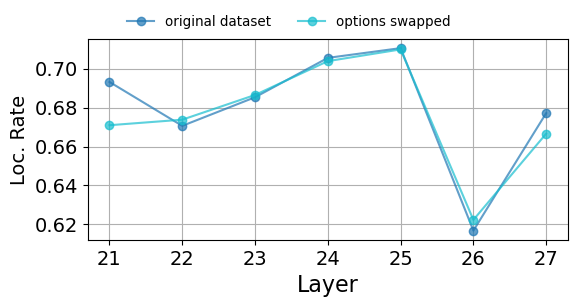

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


query = "lang!='' and alpha<3 and alpha>-3 and layer<28 and layer>20"
disp_df = steer_df.query(query).copy()

disp_df["title"] = disp_df["lang"].apply(
    lambda x: "" if x == "English" else ""
)

disp_df_alpha2 = disp_df[disp_df["alpha"] == 2].copy()


subtasks = disp_df_alpha2["title"].unique()
fig, axes = plt.subplots(len(subtasks), 1, figsize=(6, 3), sharex=True, sharey=False)
if not isinstance(axes, np.ndarray):
    axes = [axes]  # Ensure an iterable of axes if there's only one subplot

vector_types = ["perculture_en", "perculture_en_swapped"]

colors = plt.cm.tab10(np.linspace(0, 1, len(vector_types)))
vector_color_map = dict(zip(vector_types, colors))

vec_title = {
    "perculture_en": "original dataset",
    "perculture_en_swapped": "options swapped",
}

# Set up some style preferences
plt.rcParams.update({'font.size': 14})
plt.rcParams.update({'xtick.labelsize': 12, 'ytick.labelsize': 12, 'axes.labelsize': 13})

for ax, (title_value, group) in zip(axes, disp_df_alpha2.groupby("title")):
    hint_q = "lang=='English'" if title_value == "English" else "lang!='English'"
    hinted_subs = w_context.query(hint_q)

    for vec in vector_types:
        vec_df = group[group["vector"] == vec]
        if vec_df.empty:
            continue
        
        # Group by layer to get list of local_ans values
        layer_groups = vec_df.groupby("layer")["local_ans"].apply(list)
        
        # Sort layers numerically
        layers = sorted(layer_groups.index)
        
        means, ci_low, ci_high = [], [], []
        
        for lyr in layers:
            arr = np.array(layer_groups.loc[lyr], dtype=float)
            m = arr.mean()
            # Standard error of the mean
            sem = arr.std(ddof=1) / np.sqrt(len(arr))
            ci = 1.96 * sem  # 95% CI ~ ±1.96 * SEM
            
            means.append(m)
            ci_low.append(m - ci)
            ci_high.append(m + ci)
        
        # Plot line and fill for CI
        color = vector_color_map[vec]
        ax.plot(
            layers, means,
            label=vec_title[vec], 
            color=color,
            marker='o',
            alpha=0.7,
        )

    ax.plot()
    ax.set_title(title_value)
    ax.set_ylabel("Loc. Rate")  # or "Loc. Rate"
    ax.yaxis.set_major_locator(plt.MaxNLocator(nbins=6))
    ax.grid(True)
    # Add a single legend for the entire figure
    handles, labels = [], []
    for ax in axes:
        for handle, label in zip(*ax.get_legend_handles_labels()):
            if label not in labels:
                handles.append(handle)
                labels.append(label)

axes[-1].set_xlabel("Layer")
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=4, fontsize='x-small', frameon=False)

for ax in axes:
    ax.tick_params(axis='both', which='major', labelsize=14)

# Make x label and y label font size larger
axes[-1].set_xlabel("Layer", fontsize=16)
for ax in axes:
    ax.set_ylabel("Loc. Rate", fontsize=14)
# Move legend to the top

plt.tight_layout(pad=1.1)
# Save the figure

plt.tight_layout()
plt.show()
fig.savefig("original_vs_swapped.pdf", dpi=300, bbox_inches='tight')